# E-01. 가위바위보 이미지 분류기


## 1. 데이터 준비 
- 뒷 배경을 벽만 나오도록 하고 찍음
- 처음에는 가위, 바위, 보 각 100장씩 만듦, 이때 손톱에 매니큐어 발라져 있던 상태
- 학습양이 부족하여 400장으로 늘림, 매니큐어 지우고 학습시킴(다른 이미지의 경우 매니큐어가 없을 것을 대비)
- 왼손, 오른손 둘 다 학습 시킴, 손등 손바닥 방향 다 찍음 
- 거리를 앞 뒤로 두면서 사진 사이즈를 다양하게 저장

In [2]:
from PIL import Image
import glob
import os
import matplotlib.pyplot as plt

print("PIL 라이브러리 import 완료!")

PIL 라이브러리 import 완료!


In [3]:
# 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
def resize_images(img_path):
    images=glob.glob(img_path + "/*.jpg")  
    
    print(len(images), " images to be resized.")

    target_size=(28,28)
    
    for img in images:
        old_img=Image.open(img)
        new_img=old_img.resize(target_size,Image.ANTIALIAS)
        new_img.save(img, "JPEG")
    
    print(len(images), " images resized.")


In [4]:
# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/scissor"
resize_images(image_dir_path)

print("가위 이미지 resize 완료!")

399  images to be resized.
399  images resized.
가위 이미지 resize 완료!


In [5]:
# 바위 이미지
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/rock"
resize_images(image_dir_path)
print("바위 이미지 resize 완료!")

395  images to be resized.
395  images resized.
바위 이미지 resize 완료!


In [6]:
# 보 이미지
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/paper"
resize_images(image_dir_path)
print("보 이미지 resize 완료!")

400  images to be resized.
400  images resized.
보 이미지 resize 완료!


In [7]:
import numpy as np


def load_data(img_path, number_of_data=1194):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper"
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 1194 입니다.
x_train shape: (1194, 28, 28, 3)
y_train shape: (1194,)


라벨:  0


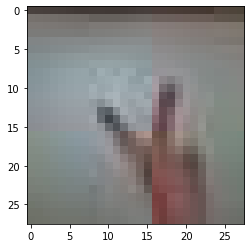

In [8]:
plt.imshow(x_train[200])
print('라벨: ', y_train[200])

## 2. 딥러닝 네트워크 설계하기 
- 바꿔 볼 수 있는 하이퍼파라미터들 하나씩 다 확인해봄 : 제대로 된 하이퍼파라미터를 찾지 못함 
에폭을 10 -> 15로 증가해서 정확도가 올라간건지 아니면 학습을 한번 더 해서 올라갔는지 모르겠지만 정확도 올라감 /  채널 1 16->32로 올림, 0.333으로 더 낮게 나옴 / dense를 올려봄 16 -> 32, test 정확도가 떨어짐 /dense 16 -> 8  정확도 떨어짐
막연하게 그냥 숫자만 넣어서 제대로 된 값을 찾지 못함 

1. 두번째 돌릴때(학습데이터 증가) 원래대로 에폭 10으로 하고 돌려봄
2. 에폭 20
3. n_channel_1=32, 에폭 10
4. 에폭 30 
5. 에폭 50
6. 학습데이터 늘림 600 -> 1194
7. 층 하나 더 늘림 Conv2D, MaxPooling2D 층을 늘리면 복잡해져서 정확도 더 떨어짐
8. n_channel_1=25 (기존 16) 정확도 떨어짐
9. n_channel_1=27 훈련셋 정확도는 올라가지만 테스트셋은 떨어짐
10. model.add(keras.layers.Dropout(0.5)) 과적합 방지
11. 드랍아웃에 에폭 50으로 늘림 
12. 다시 다 끄고 처음부터 하면 정확도 0.33 나와서 에폭 200으로 늘림 test_accuracy: 0.6000000238418579
13. 에폭 250 도전  test_accuracy: 0.6366666555404663
이때 n_dense = 16으로 되어 있는 것을 이제서야 봄.... 다시 dense값 32로 변경
최종으로 현재 모델로 확정

여러 하이퍼파라미터를 바꿔보았지만 테스트 셋 정확도가 계속 낮게 나옴

왜 이렇게 낮게 나오는지 고민해봤을 때 내가 만들었던 데이터에 문제가 있는것 같음

사진에서 왼쪽 오른쪽까지 다 나오게 찍었지만 문제는 손톱에 매니큐어가 칠해져있어서 매니큐어가 있고 없고에도 영향이 있을 것 같음, 그래서 다시 데이터를 바꾸고 해보기로 함 
현재 로스값과 정확도는
test_loss: 8.044198036193848 
test_accuracy: 0.33666667342185974

- 매니큐어를 다 지우고 왼손 오른손 둘다 찍어서 다시 위의 단계를 실행 해보기로 함
- 거리를 가깝게 멀게 해서 다양한 거리로 찍음
- 가위 학습 데이터를 만들 때 검지,엄지 / 엄지, 중지 두 가지 다 저장함
- 비교를 위해 테스트셋은 변경하지 않고 그대로 진행 

위와 같이 재정비 후 위의 코드 다시 실행해봄

1.학습데이터 값 600개 일때 
test_loss: 6.319207668304443 
test_accuracy: 0.3933333456516266
로스값은 낮아졌지만 정확도가 그렇게 좋게 나오진 않음

2.에폭 20으로 변경시
test_loss: 6.775516510009766 
test_accuracy: 0.4000000059604645

3.학습단계에서 너무 낮게 나와서 테스트 안함

4.에폭 30으로 변경시
test_loss: 1.3429734706878662 
test_accuracy: 0.6299999952316284    

5.에폭 50으로 변경시 
test_loss: 6.187368392944336 
test_accuracy: 0.4566666781902313


6.학습데이터 늘림 600 -> 1194, 에폭 30
test_loss: 6.074407577514648 
test_accuracy: 0.5299999713897705

9.n_channel_1=27
test_loss: 6.270820140838623 
test_accuracy: 0.4633333384990692

11.드랍아웃에 에폭을 30만 넣으니 학습 정확도가 95% 넘지 않아서 에폭을 50으로 늘림
test_loss: 1.1245529651641846 
test_accuracy: 0.7666666507720947  <<< 드디어 76.66%의 정확도가 나옴!!!! 
높게 나와서 행복했지만 다시 주피터노트북 다 끄고 실행했을때는 높게 나오지 않음 저 수치는 저때 한번 빼고 그 뒤에 보지 못했다는 슬픈 소식....

> 학습 데이터 양이 너무 적으면 안됨 600개로는 어림도 없었음 
> 그냥 에폭을 늘리면 과적합으로 인해 훈련셋 정확도는 올라가도 테스트셋 정확도가 떨어짐(의미X) 
> 과적합을 방지하고자 Dropout을 넣고, 에폭을 늘렸더니 훈련셋과 테스트셋 정확도가 둘다 향상하는 것을 보임 

In [8]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

# model을 직접 만들어 보세요.
# Hint! model의 입력/출력부에 특히 유의해 주세요. 가위바위보 데이터셋은 MNIST 데이터셋과 어떤 점이 달라졌나요?


n_channel_1=16
n_channel_2=32
n_dense= 32
n_train_epoch= 30

model=keras.models.Sequential()
#입력된 사진은 컬러이므로 input_shape의 마지막은 3을 넣어야함, 흑백의 경우 1
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))


# 최종 분류 class의 수는 3개(가위, 바위, 보)이므로 3 입력되어야함
model.add(keras.layers.Dense(3, activation='softmax'))


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                2

## 3. 딥러닝 네트워크 학습시키기

In [9]:
# model을 학습시키는 코드를 직접 작성해 보세요.
# Hint! model.compile()과 model.fit()을 사용해 봅시다.

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 에폭을 10으로 했을 때 정확도가 0.33 나와서 15로 늘림
#-----------------------------------------------------
# 1. 두번째 돌릴때(학습데이터 늘림) 정확도는(에폭 그대로 10)? loss: 0.1832 - accuracy: 0.9433
# 한번만 돌렸지만 매우 높은 정확도와 낮은 로스값을 보임
# 2. 에폭 20으로 올림 loss: 0.0694 - accuracy: 0.9900
# 3. loss: 0.2982 - accuracy: 0.8867 더 떨어짐 테스트셋 패스

model.fit(x_train, y_train, epochs=n_train_epoch)  # check 변수로 받고

Epoch 1/30
38/38 [==============================] - 3s 5ms/step - loss: 9.5805 - accuracy: 0.3434
Epoch 2/30
38/38 [==============================] - 0s 3ms/step - loss: 1.1016 - accuracy: 0.4841
Epoch 3/30
38/38 [==============================] - 0s 3ms/step - loss: 0.9221 - accuracy: 0.5871
Epoch 4/30
38/38 [==============================] - 0s 3ms/step - loss: 0.7999 - accuracy: 0.6466
Epoch 5/30
38/38 [==============================] - 0s 3ms/step - loss: 0.7130 - accuracy: 0.7069
Epoch 6/30
38/38 [==============================] - 0s 3ms/step - loss: 0.5677 - accuracy: 0.7680
Epoch 7/30
38/38 [==============================] - 0s 3ms/step - loss: 0.5632 - accuracy: 0.7714
Epoch 8/30
38/38 [==============================] - 0s 3ms/step - loss: 0.4335 - accuracy: 0.8375
Epoch 9/30
38/38 [==============================] - 0s 3ms/step - loss: 0.4181 - accuracy: 0.8300
Epoch 10/30
38/38 [==============================] - 0s 3ms/step - loss: 0.3656 - accuracy: 0.8543
Epoch 11/30
38/38 [

In [10]:
# 테스트 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/scissor"
resize_images(image_dir_path)

print("테스트 가위 이미지 resize 완료!")

100  images to be resized.
100  images resized.
테스트 가위 이미지 resize 완료!


In [11]:
# 테스트 바위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/rock"
resize_images(image_dir_path)

print("테스트 바위 이미지 resize 완료!")

100  images to be resized.
100  images resized.
테스트 바위 이미지 resize 완료!


In [12]:
# 테스트 보 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/paper"
resize_images(image_dir_path)

print("테스트 보 이미지 resize 완료!")

100  images to be resized.
100  images resized.
테스트 보 이미지 resize 완료!


In [13]:
def load_data(img_path, number_of_data=300):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("테스트데이터(x_test)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test"
(x_test, y_test)=load_data(image_dir_path)
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

테스트데이터(x_test)의 이미지 개수는 300 입니다.
x_test shape: (300, 28, 28, 3)
y_test shape: (300,)


## 4. 얼마나 잘 만들었는지 확인하기 

In [14]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

10/10 [==============================] - 0s 6ms/step - loss: 2.5670 - accuracy: 0.6467
test_loss: 2.5669920444488525 
test_accuracy: 0.6466666460037231


In [15]:
predicted_result = model.predict(x_test)  # model이 추론한 확률값. 
predicted_labels = np.argmax(predicted_result, axis=1)

idx=5  #5번째 x_test를 살펴보자. 
print('model.predict() 결과 : ', predicted_result[idx])
print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
print('실제 데이터의 라벨 : ', y_test[idx])

model.predict() 결과 :  [0.51921326 0.00058708 0.48019964]
model이 추론한 가장 가능성이 높은 결과 :  0
실제 데이터의 라벨 :  0


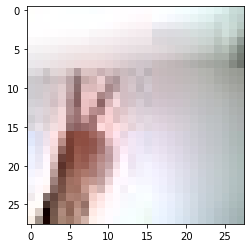

In [16]:
plt.imshow(x_test[idx],cmap=plt.cm.binary)
plt.show()

예측확률분포: [3.4095272e-05 9.2302704e-01 7.6938838e-02]
라벨: 0, 예측결과: 1


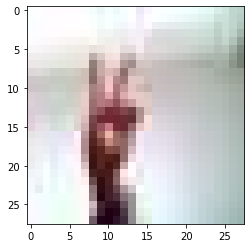

예측확률분포: [1.8494015e-05 9.8780340e-01 1.2178112e-02]
라벨: 0, 예측결과: 1


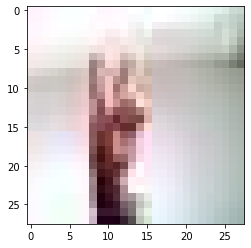

예측확률분포: [0.02271597 0.26090422 0.7163798 ]
라벨: 0, 예측결과: 2


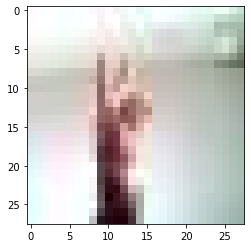

예측확률분포: [0.00134711 0.97941476 0.01923818]
라벨: 2, 예측결과: 1


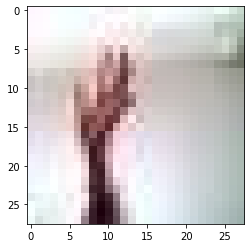

예측확률분포: [0.02271597 0.26090422 0.7163798 ]
라벨: 0, 예측결과: 2


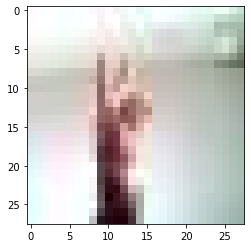

In [17]:
import random
wrong_predict_list=[]
for i, _ in enumerate(predicted_labels):
    # i번째 test_labels과 y_test이 다른 경우만 모아 봅시다. 
    if predicted_labels[i] != y_test[i]:
        wrong_predict_list.append(i)

# wrong_predict_list 에서 랜덤하게 5개만 뽑아봅시다.
samples = random.choices(population=wrong_predict_list, k=5)

for n in samples:
    print("예측확률분포: " + str(predicted_result[n]))
    print("라벨: " + str(y_test[n]) + ", 예측결과: " + str(predicted_labels[n]))
    plt.imshow(x_test[n], cmap=plt.cm.binary)
    plt.show()

1. metrics = check.history 
2. plt.plot(history.epoch, metrics['accuracy'], metrics['loss'])
3. plt.legend(['accuracy', 'loss'])
4. plt.show()
5. 변수 check를 받고 위의 코드 돌리면 그래프 그려짐 